In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
basepath = '/scistor/ivm/jsn295/bootstrap/max_depth=5.n_estimators=1500.min_samples_split=20.max_features=0.15.n_jobs=21.bs.parquet'

In [134]:
df = pd.read_parquet(basepath)

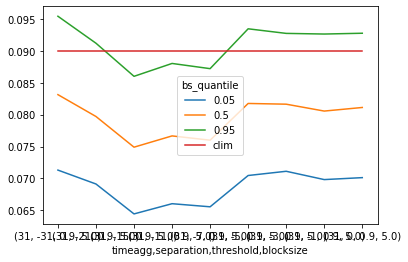

In [17]:
df.loc[(31,slice(None),0.9,5.0),:].plot()

This one is pretty interesting. So there seems to be a window of certain leadtimes in which this is better predictable. (bootstrap bounds are too small however, 31 timeagg needs blocks of at least 30).

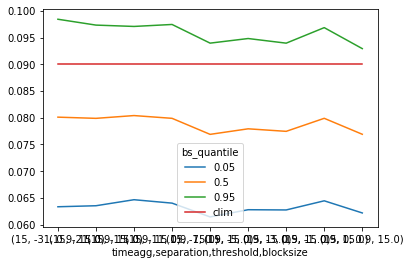

In [21]:
df.loc[(15,slice(None),0.9,15.0),:].plot()

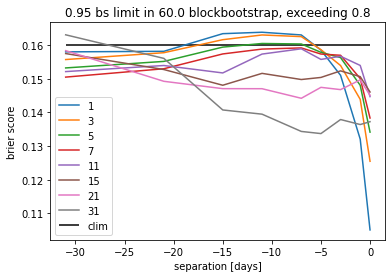

In [100]:
# Plotting the upper bound for this threshold with different timeaggs against separation
threshold = 0.8
blocksize = 60.0
fig,ax = plt.subplots()
for timeagg in df.index.get_level_values('timeagg').unique().sort_values():
    select = df.loc[(timeagg,slice(None),threshold,blocksize),['0.95','clim']]
    ax.plot(select.index.get_level_values('separation'),select['0.95'], label = str(timeagg))
ax.hlines(select.iloc[0,-1], xmin = df.index.get_level_values('separation').min(), xmax = df.index.get_level_values('separation').max(),label = 'clim')
ax.set_xlabel('separation [days]')
ax.set_ylabel('brier score')
ax.set_title(f'0.95 bs limit in {blocksize} blockbootstrap, exceeding {threshold}')
ax.legend()

This is very interesting. Apparently anything of a duration lower that 7 days are very hard to forecast from -20 to -7 days. You also see that the blue curve drops of earlier (the event to be forecasted is less into the future). Interestingly the slope of 15, 21 and 31 days is just gradual. 11 is hardly heeling.
You see exactly the same pattern for the different bootstrap levels (and/or median). Not so sure if also the same pattern for the different thresholds

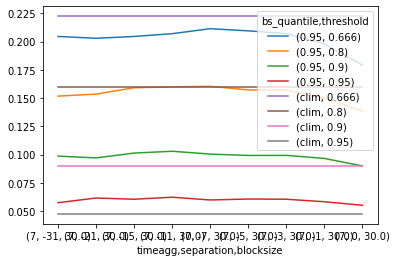

In [74]:
df.loc[(7,slice(None),slice(None),30.0),['0.95','clim']].unstack(2).plot()

You see more curvature for the lower thresholds. Also extremes pretty much unpredictable. But perhaps this is just the brier score scaling. Transform to skillscore?

In [135]:
for quantile in ['0.05','0.5','0.95']:
    df[f'{quantile}_skill'] = 1 - df[quantile] / df['clim']

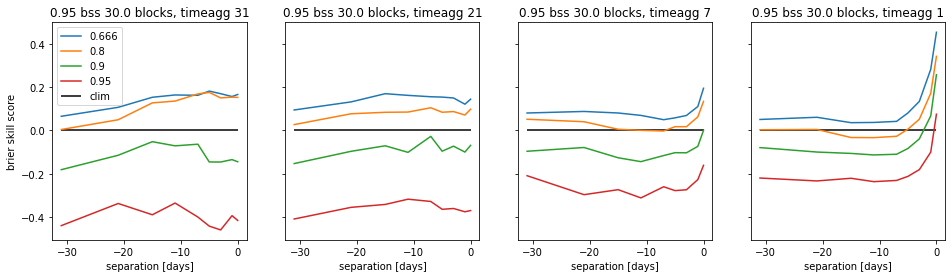

In [102]:
blocksize = 30.0
timeaggs = [1,7,21,31][::-1]
fig,axes = plt.subplots(ncols = len(timeaggs), squeeze = False, sharey=True, figsize = (4*len(timeaggs),4))
for i, timeagg in enumerate(timeaggs):
    ax = axes[0,i]
    for threshold in df.index.get_level_values('threshold').unique().sort_values():
        selection = df.loc[(timeagg,slice(None),threshold,blocksize),['0.95_skill']]
        ax.plot(selection.index.get_level_values('separation'),selection, label = str(threshold))
    ax.hlines(0, xmin = df.index.get_level_values('separation').min(), xmax = df.index.get_level_values('separation').max(),label = 'clim')
    ax.set_xlabel('separation [days]')
    if i == 0:
        ax.set_ylabel('brier skill score')
        ax.legend()
    ax.set_title(f'0.95 bss {blocksize} blocks, timeagg {timeagg}')


Thresholds show similar curvature (except for timeagg = 31).
Why would the predictive skill remain flat with decreasing separation for the larger time aggregations, and the more extreme thresholds. (Not being able to use persistence of the synoptic?)
Quality of information should be the same per separation. So quality differences for the separations might explain curves (though then these shapes should be present regardless of the resptimeagg and the exceedence threshold).
Conceptually it might be something like 'missing' the opportunity of the teleconnection or feedback mechanism, because the causility path takes too long (affects too late after the current combination of gap-size plus response timeagg)

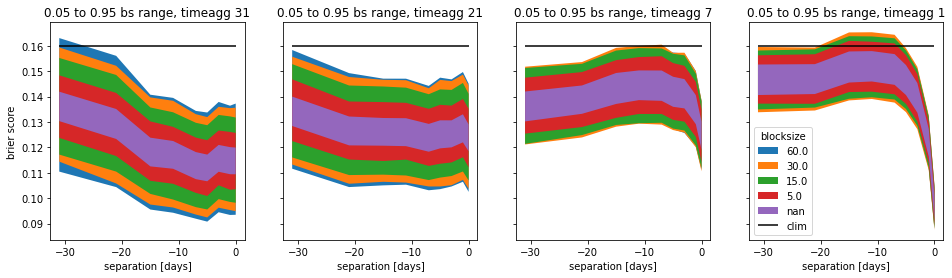

In [132]:
# Demonstration of the effect of different block bootstrap sizes. in terms of bs
threshold = 0.8
timeaggs = [1,7,21,31][::-1]
fig,axes = plt.subplots(ncols = len(timeaggs), squeeze = False, sharey=True, figsize = (4*len(timeaggs),4))
fig.patch.set_facecolor('white')
for i, timeagg in enumerate(timeaggs):
    ax = axes[0,i]
    for blocksize in df.index.get_level_values('blocksize').unique()[::-1]:
        selection = df.loc[(timeagg,slice(None),threshold,blocksize),['0.05','0.95','clim']]
        ax.fill_between(x = selection.index.get_level_values('separation'), y1 = selection['0.05'], y2 = selection['0.95'],label = str(blocksize))
    ax.set_xlabel('separation [days]')
    ax.hlines(y = selection['clim'].iloc[0], xmin = df.index.get_level_values('separation').min(), xmax = df.index.get_level_values('separation').max(),label = 'clim')
    ax.set_title(f'0.05 to 0.95 bs range, timeagg {timeagg}')
    if i == 0:
        ax.set_ylabel('brier score')
    if i == len(timeaggs) - 1:
        ax.legend(title = 'blocksize', loc = 'lower left')

One can note that the widest uncertainty range is usually for the largest timescales. Not necessarily in terms of the purple area, but actually the widening by the block-bootstrapping. I am curious to compare different thresholds. So let's visualize this in terms of the skillscore (to remain comparable)

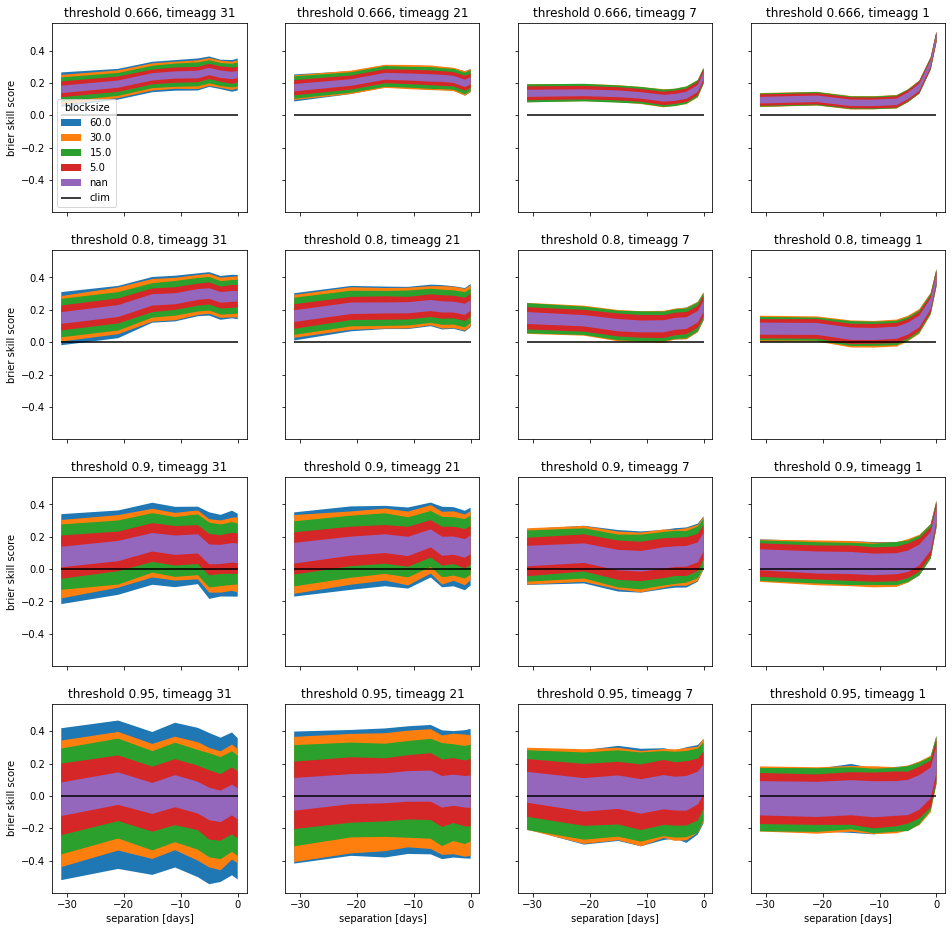

In [142]:
# Demonstration of the effect of different block bootstrap sizes. in terms of skill score
thresholds = df.index.get_level_values('threshold').unique().sort_values()
timeaggs = [1,7,21,31][::-1]
fig,axes = plt.subplots(ncols = len(timeaggs), nrows = len(thresholds), squeeze = False, sharey=True, sharex = True, figsize = (4*len(timeaggs),4*len(thresholds)))
fig.patch.set_facecolor('white')
for i, threshold in enumerate(thresholds):
    for j, timeagg in enumerate(timeaggs):
        ax = axes[i,j]
        for blocksize in df.index.get_level_values('blocksize').unique()[::-1]:
            selection = df.loc[(timeagg,slice(None),threshold,blocksize),['0.05_skill','0.95_skill']]
            ax.fill_between(x = selection.index.get_level_values('separation'), y1 = selection['0.05_skill'], y2 = selection['0.95_skill'],label = str(blocksize))
        
        ax.hlines(y = 0, xmin = df.index.get_level_values('separation').min(), xmax = df.index.get_level_values('separation').max(),label = 'clim')
        ax.set_title(f'threshold {threshold}, timeagg {timeagg}')
        if j == 0:
            ax.set_ylabel('brier skill score')
        if i == len(thresholds) - 1:
            ax.set_xlabel('separation [days]')
            
axes[0,0].legend(title = 'blocksize', loc = 'lower left')

Looking at this, you just see that extremes are harder to predict. But there is a hint of windows. For instance the threshold 0.9 at long timeaggs and a not so strict bootstrapping has shown skill.

In terms of skillfull opportunities, also the 'dip' in skill of forecasting 7day exceedance of 0.8 is very interesting.

In [ ]:
# I should complement this with reliability diagrams. As the bs for the different thresholds has different uncertainty terms.